# Creek

1. Blacken some cells of the grid resp. 
2. A number in a circle indicates how many of the 4 adjacent cells must be blackened.
3. All white cells must form a single **orthogonally contiguous** area.

-----

1. 将网格的某些单元格涂黑.
2. 圆圈中的数字表示 4 个相邻单元格中有多少个必须变黑。
3. 所有白细胞必须形成一个**正交连续**的区域。

![](https://www.janko.at/Raetsel/Creek/Regeln-01.gif) ![](https://www.janko.at/Raetsel/Creek/Regeln-02.gif)

In [1]:
from ortools.sat.python import cp_model as cp
import gurobipy as gp
from collections import deque
from itertools import chain
# ===== vsualzie ===== 
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
from matplotlib.pyplot import MultipleLocator


In [6]:
def readGrid(path):
    with open(f"../assets/data/Creek/problems/{path}.txt") as f:
        num = f.readline()
        m, n = num.split(" ")[0], num.split(" ")[1]
        grid = f.readlines()
        res = [g.strip().split(" ") for g in grid]
        return int(m), int(n), res

if __name__ == "__main__":
    m, n, grid = readGrid("345_25x40")
    for g in grid:
        print(g)

['-', '2', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '1', '-', '-', '-', '1', '-', '-', '-', '-', '-', '1', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '1', '-', '0']
['-', '-', '2', '1', '2', '3', '2', '-', '-', '2', '1', '2', '-', '-', '-', '-', '-', '2', '-', '-', '3', '-', '2', '-', '2', '-', '2', '2', '-', '-', '3', '-', '2', '2', '-', '3', '-', '-', '-', '-', '-']
['-', '3', '-', '-', '2', '-', '-', '3', '-', '-', '-', '-', '-', '-', '2', '-', '-', '-', '2', '-', '-', '-', '-', '2', '-', '-', '0', '2', '-', '-', '-', '-', '-', '-', '-', '4', '-', '-', '-', '-', '2']
['-', '1', '2', '-', '-', '-', '-', '-', '-', '2', '-', '3', '-', '2', '2', '-', '3', '-', '-', '-', '2', '-', '-', '1', '1', '2', '-', '-', '-', '-', '2', '-', '3', '-', '-', '3', '-', '-', '4', '-', '-']
['1', '-', '-', '-', '-', '2', '-', '-', '2', '-', '-', '-', '2', '2', '1', '-', '2', '3', '-', '1', '1', '2', '1', '1', '1', '1', '2', '-', '-', '-', '-', '1', '-', '-', '2', 

In [8]:
def CreekSolver(m, n, grid) :
    """_summary_

    Args:
        m (_type_): # of rows, int
        n (_type_): # of cols, int 
        grid (_type_): the grid, list(list(str))
    """
    
    Creek = gp.Model("Creek")
    Creek.modelSense = gp.GRB.MAXIMIZE
    Creek.Params.lazyConstraints = 1
    Creek.update()
    x = {}
    for i in range(m):
        for j in range(n):
            x[i, j] = Creek.addVar(
            vtype = gp.GRB.BINARY,
            obj = 1,
            name = f"x[{i},{j}]")
            
    for i in range(m + 1):
        for j in range(n + 1):
            if grid[i][j] not in [".", "-"]:
                neighbours = []
                directions = [(-1, -1), (-1, 0), (0, -1), (0, 0)]
                for (subx, suby) in directions:
                    if (i + subx >= 0 and i + subx < m) and (j + suby >= 0 and j + suby < n):
                        neighbours.append((i + subx, j + suby))
                Creek.addConstr(gp.quicksum(x[subx, suby] for (subx, suby) in neighbours) == int(grid[i][j]), name = f"constr_{i}_{j}_{grid[i][j]}")

    for i in range(m):
        for j in range(n):
            neighbours = []
            directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
            for (subx, suby) in directions:
                if (i + subx >= 0 and i + subx < m) and (j + suby >= 0 and j + suby < n):
                    neighbours.append((i + subx, j + suby))
            Creek.addConstr(gp.quicksum(x[subx, suby] for (subx, suby) in neighbours) <= len(neighbours) - 1 + x[i, j], name = f"alone_{i}_{j}")
    
    Creek.setObjective(gp.quicksum(x[i, j] for i in range(m) for j in range(n)), gp.GRB.MAXIMIZE)
    # Creek.write("Creek.lp")
    def border_elim(model, where):
        if (where == gp.GRB.Callback.MIPSOL):
            x_sol = model.cbGetSolution(model._x)
            curr_grid = [[0] * n for i in range(m)]
            for i in range(m):
                for j in range(n):
                    if int(x_sol[i, j]) == 0:
                        curr_grid[i][j] = 1
                
            def find_surrounding_black_cells(grid):
                rows, cols = len(grid), len(grid[0])
                visited = set()
                directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # Up, down, left, right movements
                total_white = sum(chain.from_iterable(grid))
                # Find the first unvisited white cell
                def find_unvisited_white():
                    for i in range(rows):
                        for j in range(cols):
                            if grid[i][j] == 1 and (i, j) not in visited:
                                return (i, j)
                    return None
                borders_cut = [] # record cells that formulate the border: list(tuple)
                cells_inside_borders = [] # record all cells inside the border: list(tuple)
                cnt_white = 0
                while len(visited) < total_white:
                    start = find_unvisited_white()
                    if not start:
                        break
                    # Use BFS to find all connected white cells and record the surrounding black cells
                    queue = deque([start])
                    surrounding_black_cells = set()  # Use a set to avoid duplicates
                    current_inside_cells = [] # record cells in current border
                    while queue:
                        x, y = queue.popleft()
                        if (x, y) in visited:
                            continue
                        visited.add((x, y))
                        current_inside_cells.append((x, y))
                        cnt_white += 1
                        # Check all four adjacent directions
                        for dx, dy in directions:
                            nx, ny = x + dx, y + dy
                            if 0 <= nx < rows and 0 <= ny < cols:
                                if grid[nx][ny] == 1 and (nx, ny) not in visited:
                                    queue.append((nx, ny))
                                elif grid[nx][ny] == 0:
                                    surrounding_black_cells.add((nx, ny))
                    borders_cut.append(list(surrounding_black_cells))
                    cells_inside_borders.append(current_inside_cells)
                    
                assert len(borders_cut) == len(cells_inside_borders)

                if cnt_white == sum(chain.from_iterable(grid)) and len(borders_cut) == 1:
                    return [], []
                # borders_cut.sort(key = lambda x: len(x), reverse = True)
                return borders_cut, cells_inside_borders

            borders_cut, cells_inside_borders = find_surrounding_black_cells(curr_grid)

            for borders, cells_inside in zip(borders_cut, cells_inside_borders):
                if len(cells_inside) < m * n // 2:
                    for (cell_x, cell_y) in cells_inside:
                        model.cbLazy(gp.quicksum(model._x[subx, suby] for (subx, suby) in borders ) <= len(borders) - 1 + model._x[cell_x, cell_y])
                    
                
    Creek._x = x
    Creek.optimize(border_elim)
    # Creek.computeIIS()
    # Creek.write("Creek.ilp")
    result = [["."] * n for _ in range(m)]
    for i in range(m):
        for j in range(n):
            if x[i, j].x > 1e-6:
                print(f"X", end = " ")
                result[i][j] = "X"
            else:
                print(f".", end = " ")
        print()
    print()
    return result



    
if __name__ == "__main__":
    m, n, grid = readGrid("345_25x40")
    # 20x30: No. 367
    # 19x19: No. 391
    # 19x24: No. 392
    result = CreekSolver(m, n, grid)
    
    

Set parameter LazyConstraints to value 1
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M3 Pro
Thread count: 11 physical cores, 11 logical processors, using up to 11 threads

Optimize a model with 1386 rows, 1000 columns and 6379 nonzeros
Model fingerprint: 0x91c0294e
Variable types: 0 continuous, 1000 integer (1000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+00]
Presolve removed 829 rows and 434 columns
Presolve time: 0.01s
Presolved: 557 rows, 566 columns, 2090 nonzeros
Variable types: 0 continuous, 566 integer (566 binary)

Root relaxation: objective 5.998000e+02, 364 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  599.80000    0   10          -  599.80

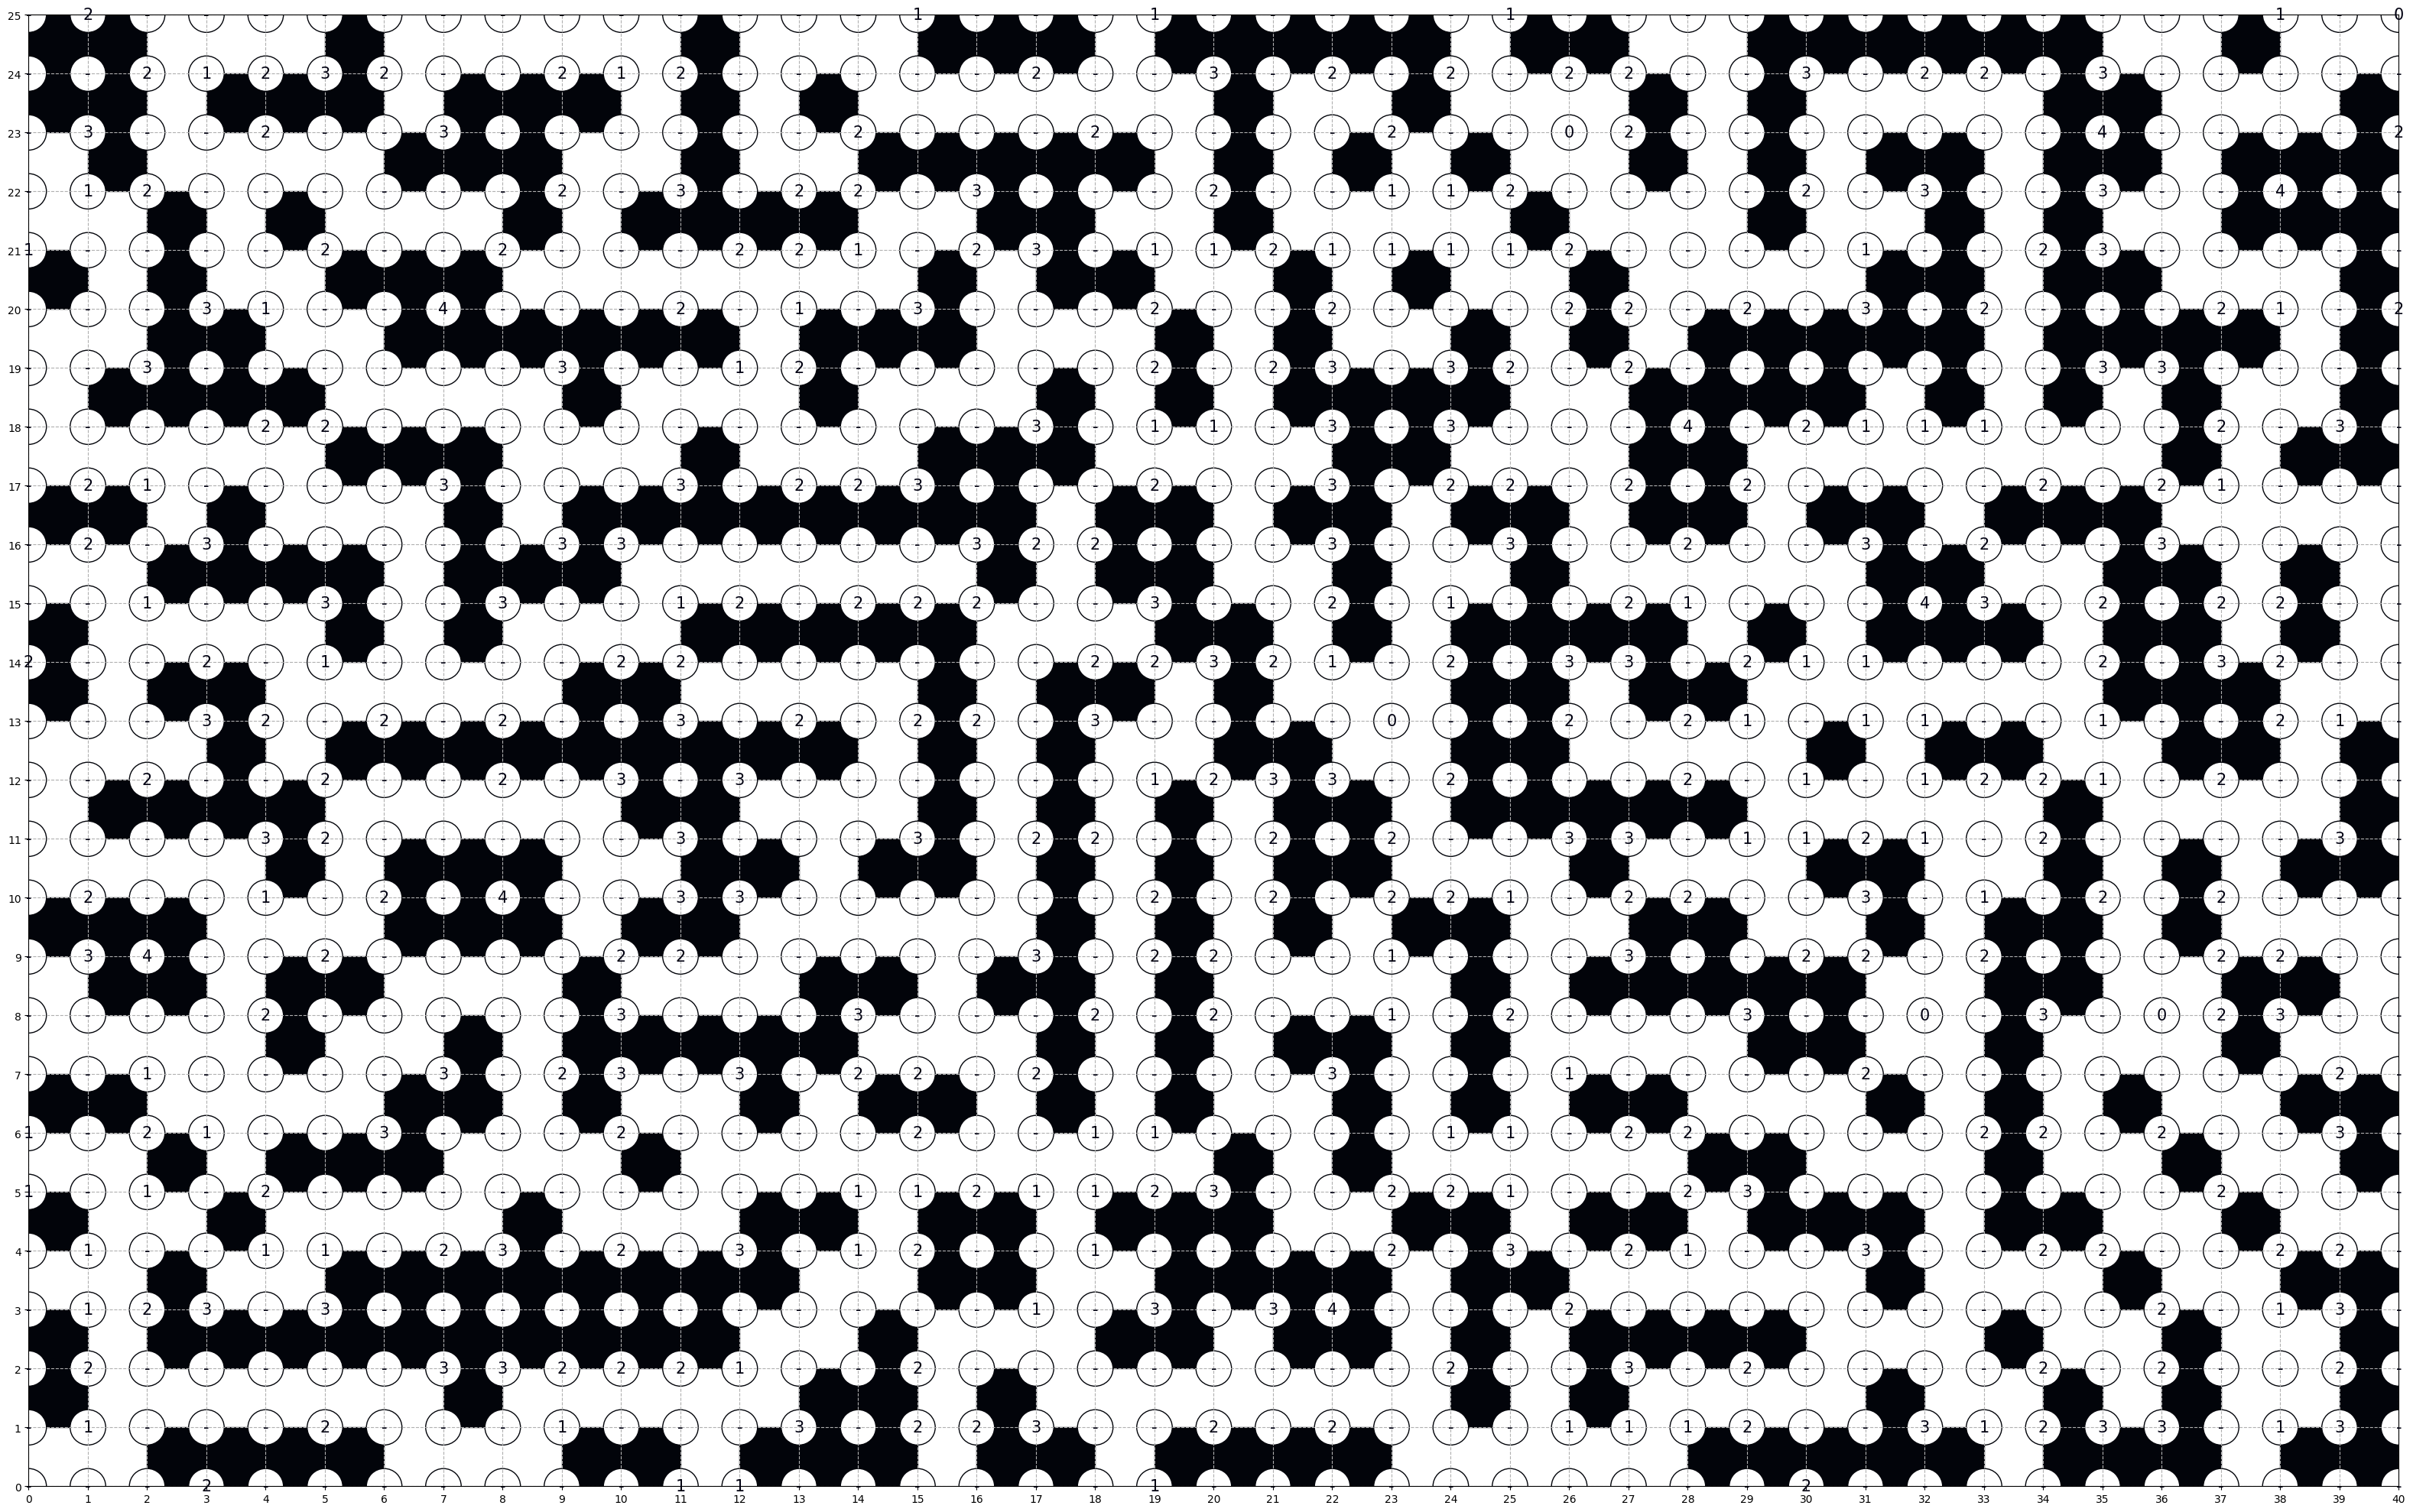

In [9]:
def visual(X, Y, grid, result):
    plt.figure(figsize = (Y, X))
    ax = plt.gca()
    x_major_locator = MultipleLocator(1)
    y_major_locator = MultipleLocator(1)
    ax.xaxis.set_major_locator(x_major_locator)
    ax.yaxis.set_major_locator(y_major_locator)
    plt.xlim(0,Y)
    plt.ylim(0,X)
    plt.grid(linestyle = "--")
    for i in range(X):
        for j in range(Y):
            if result[i][j] == "X":
                ax.add_patch(Rectangle((j, X - i - 1), 1, 1, color = "#02040A"))
    for i in range(X + 1):
        for j in range(Y + 1):
            if grid[i][j] != '.':
                ax.add_patch(Circle((j, X - i), 0.3,facecolor = "#ffffff" , edgecolor = "#02040A", linestyle = "-"))
                ax.text(j , X - i, grid[i][j], 
                            horizontalalignment = "center", 
                            verticalalignment = 'center',
                            fontsize = 15, color = "#000011")
    plt.show()
        

if __name__ == "__main__":
    visual(m, n, grid, result)